# **<font color='red'>NN BASELINE</font>**
**<font color='blue'>In this notebook i have implemented a baseline model of Neural Network (do let me know if you have any doubts or find any bugs)</font>**


* **SCOPE OF IMPROVEMENTS**
1. **i haven't tested effect of batch size**
2. **adding layers**
3. **feature engineering on combined train and test data.**
4. **analize train and test distribution carefully.**
5. **try different optimizers (Nadam,AdamW,Adagrad etc.)**
6. **try different scheduling techniques.**


# **<font color='green'>IMPORT LIBRARIES</font>**

In [ ]:


from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

sns.set_style("darkgrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore") 
        
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train=pd.read_csv("/kaggle/input/tabular-playground-series-nov-2021/train.csv")
test=pd.read_csv("/kaggle/input/tabular-playground-series-nov-2021/test.csv")

In [ ]:
print("train shape is:",train.shape)
print("test shape is:",test.shape)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
print(train[train['target']==1]['target'].value_counts())
print(train[train['target']==0]['target'].value_counts())

In [ ]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

# OBSERVATIONS
1. **No null value is present in the dataset**
2. **data has 102 columns/features including target**
3. **all 100 features are float variables**
4. **The given problem is of binary classification.**



In [ ]:
# cont_features

In [ ]:
# here i have just plotted down first  6 features you can try all of them it will take a lot of time though due to large amount of features
cont_features=list(test.columns)
print("Feature distribution of continous features: ")
ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(40,10), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.kdeplot(x=train[col], ax=axes[r, c], color='#58D68D', label='Train data')
        sns.kdeplot(x=test[col], ax=axes[r, c], color='#DE3163', label='Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=15, fontweight='bold')
        axes[r, c].tick_params(labelsize=10, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(20)
        axes[r, c].yaxis.offsetText.set_fontsize(20)
plt.show()

**INFERENCE**
*  **curves of both train and test look similar (good point) our cv will correlate with LB better.**

# **IMPORT TENSORFLOW KERAS LIBRARIES**

Here i have define 2 things:

* early stopping:if the model auc doesn't improve for 20 iterations training of that particular model will be stop

* Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 0.2 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
#import libraries
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)


plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=0,
    mode='min')

In [ ]:
train.var()

# **Quantile Transformation**
Transform features using quantiles information.

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

The transformation is applied on each feature independently. First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution. The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.

**Uncomment the last 6 lines if you want to try exploring Quantile transformer**

In [ ]:
colNames=[col for col in test.columns if col not in 'id','f2','f35','f44']
# colNames.remove('id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
train_nn=pd.concat([train_nn,test_nn])
# for col in colNames:
#     #print(col)
#     qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
#     train_nn[col] = qt.fit_transform(train_nn[[col]])
#     test_nn[col] = qt.transform(test_nn[[col]])    
# test_nn=train_nn[-test_nn.shape[0]:]
# train_nn=train_nn[:-test_nn.shape[0]]

In [ ]:
train_nn['target']=train['target']

# **KEY POINTS:**
* **Swish Activation**:The choice of activation functions in Deep Neural Networks has a significant impact on the training dynamics and task performance. Currently, the most successful and widely-used activation function is the Rectified Linear Unit (ReLU), which is f(x)=max(0,x). Although various alternatives to ReLU have been proposed, none have managed to replace it due to inconsistent gains. So Google Brain Team has proposed a new activation function, named Swish, which is simply f(x) = x · sigmoid(x). Their experiments show that Swish tends to work better than ReLU on deeper models across a number of challenging datasets. 

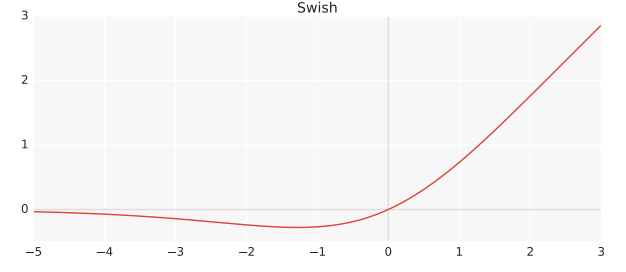

* **Input Layer** : every neural network has an input layer, we have passed shape=(100,) to it since there are 100 features in our data.

* **Hidden Layers** :In neural networks, a hidden layer is located between the input and output of the algorithm, in which the function applies weights to the inputs and directs them through an activation function as the output. In short, the hidden layers perform nonlinear transformations of the inputs entered into the network. here we have three hidden layers of units (100,64,32) units.

* **Output Layers** :There must always be one output layer in a neural network. The output layer takes in the inputs which are passed in from the layers before it, performs the calculations via its neurons and then the output is computed. here we have used sigmoid activation.Image below is the diagram of sigmid activation.

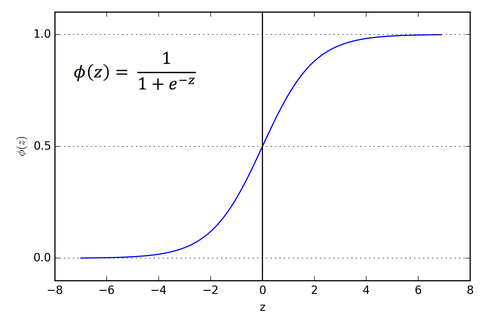

In [ ]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
from sklearn.metrics import roc_auc_score
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)#initialized number of neurons in each hidden layer

def base_model():

    num_input = keras.Input(shape=(test.shape[1],), name='num_data')#input layer


    out = keras.layers.Concatenate()([num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted target value probability
    out = keras.layers.Dense(1, activation='sigmoid', name='prediction')(out)
    
    model = keras.Model(
    inputs = [num_input],
    outputs = out,
    )
    
    return model

# **Key points:**

*  **Validation strategy**: here i have used Kfold strategy, the data is divided into 5 folds , 4 of them are used for training and 1 of them is used for validation this will happen 5 times.
* **Loss=binary cross entropy**: for understanding this you can refer this link :https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
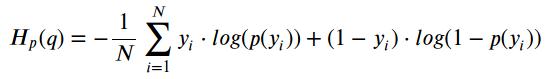
* **Metrics=AUC**:This is the metrics we have to use in this competition.

* **Batch size**:Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration. so our training examples are going into our network in batches here specifically they are going in the batches of 2048, you can try tweaking it and check what happens if we change it.

In [ ]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for fold, (trn_ind, val_ind) in enumerate(kf.split(train,train['target'])):
    print(f'Training fold {fold + 1}')
    X_train, X_test = train_nn.iloc[trn_ind][features_to_consider], train_nn.iloc[val_ind][features_to_consider]
    y_train, y_test = train_nn.iloc[trn_ind]['target'], train_nn.iloc[val_ind]['target']
    print('CV {}/{}'.format(counter, n_folds)) 
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.001),
#          keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        loss='binary_crossentropy',
        metrics = ['AUC']
    )
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(0, 1))         
    num_data = scaler.fit_transform(num_data.values)    
      
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)

    model.fit([num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([num_data_test]).reshape(1,-1)[0]
    score = round(roc_auc_score(y_test,preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    
    test_predictions_nn += model.predict([tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds       
    counter += 1

In [ ]:
print(scores_folds)

In [ ]:
sub=pd.read_csv("../input/tabular-playground-series-nov-2021/sample_submission.csv")
sub['target']=test_predictions_nn

In [ ]:
sub

In [ ]:
sub.to_csv("submission.csv",index=False)